In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [2]:
data=pd.read_csv('city_day_new.csv')

In [3]:
cols=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3','Benzene','Toluene','Xylene']

X=data[cols]
y=data['AQI_bucket_calculated']

In [4]:
y.value_counts()

2    10639
1     9079
3     2979
4     2420
5     1595
0     1445
Name: AQI_bucket_calculated, dtype: int64

# Combining Oversampling and Undersampling Method

### - Oversampling by SMOTE followed by Undersampling by NCR

In [5]:
from imblearn.over_sampling import SMOTE

In [6]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

In [7]:
X_res.shape

(63834, 12)

In [8]:
y_res.value_counts()

2    10639
4    10639
5    10639
3    10639
1    10639
0    10639
Name: AQI_bucket_calculated, dtype: int64

In [9]:
from imblearn.under_sampling import NeighbourhoodCleaningRule 
ncr = NeighbourhoodCleaningRule(n_neighbors=5, threshold_cleaning=0.5) 

X_ncr, y_ncr =ncr.fit_resample(X_res, y_res)

In [10]:
X_ncr.shape

(57245, 12)

In [11]:
y_ncr.value_counts()

0    10639
5    10476
4    10039
3     9827
1     8564
2     7700
Name: AQI_bucket_calculated, dtype: int64

# Testing the Model

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_ncr,y_ncr,test_size=0.40,random_state=42)

# 1. Naive Bayes (SMOTE+NCR)

In [13]:
from sklearn.naive_bayes import GaussianNB
nb_smote_ncr_model = GaussianNB()

nb_smote_ncr_model.fit(X_train,y_train)

y_pred_ncr = nb_smote_ncr_model.predict(X_test)

# predict probabilities
nb_smote_ncr_pred_prob = nb_smote_ncr_model.predict_proba(X_test)

In [14]:
from sklearn import metrics
acc_score_nb_afteros_us = metrics.accuracy_score(y_test, y_pred_ncr)
f1_score_nb_afteros_us = metrics.f1_score(y_test, y_pred_ncr,average='weighted')
precision_nb_afteros_us = metrics.precision_score(y_test, y_pred_ncr,average='weighted')
recall_nb_afteros_us = metrics.recall_score(y_test, y_pred_ncr,average='weighted')

print("Accuracy:",acc_score_nb_afteros_us.round(4))
print("Weighted F1 Score:",f1_score_nb_afteros_us.round(4))
print("Weighted Precision:",precision_nb_afteros_us.round(4))
print("Weighted Recall:",recall_nb_afteros_us.round(4))

Accuracy: 0.7106
Weighted F1 Score: 0.7089
Weighted Precision: 0.7105
Weighted Recall: 0.7106


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_ncr))
print(classification_report(y_test, y_pred_ncr))

[[3644  415  131   12    0   19]
 [1071 1995  349   31    1    9]
 [  74  570 2128  294   31   32]
 [  20   25  441 2916  422  142]
 [   0    3    1 1057 2415  470]
 [   1    0    1   66  938 3174]]
              precision    recall  f1-score   support

           0       0.76      0.86      0.81      4221
           1       0.66      0.58      0.62      3456
           2       0.70      0.68      0.69      3129
           3       0.67      0.74      0.70      3966
           4       0.63      0.61      0.62      3946
           5       0.83      0.76      0.79      4180

    accuracy                           0.71     22898
   macro avg       0.71      0.70      0.70     22898
weighted avg       0.71      0.71      0.71     22898



In [16]:
CM = confusion_matrix(y_test, y_pred_ncr)

FP = CM.sum(axis=0) - np.diag(CM)  
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('TPR:',TPR.round(4))
print('FPR:',FPR.round(4))
print('ACC:',ACC.round(4))

TPR: [0.8633 0.5773 0.6801 0.7352 0.612  0.7593]
FPR: [0.0624 0.0521 0.0467 0.0771 0.0734 0.0359]
ACC: [0.9239 0.892  0.916  0.8904 0.8723 0.9267]


ROC_AUC Score: 0.9398494920735008


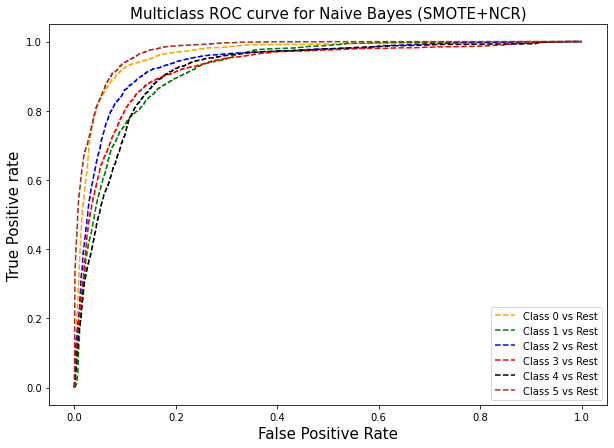

In [17]:
# roc curve for classes
plt.figure(figsize=(10,7))

fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, nb_smote_ncr_pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for Naive Bayes (SMOTE+NCR)',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive rate',fontsize=15)
plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300)

print('ROC_AUC Score:',roc_auc_score(y_test, nb_smote_ncr_pred_prob,multi_class='ovr'))

# 2. KNN (SMOTE+NCR)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn_smote_ncr_model  = KNeighborsClassifier(n_neighbors=5)
knn_smote_ncr_model.fit(X_train, y_train)

y_pred_ncr = knn_smote_ncr_model.predict(X_test)

# predict probabilities
knn_smote_ncr_pred_prob = knn_smote_ncr_model.predict_proba(X_test)

In [19]:
acc_score_knn_afteros_us=metrics.accuracy_score(y_test, y_pred_ncr)
f1_score_knn_afteros_us=metrics.f1_score(y_test, y_pred_ncr,average='weighted')
precision_knn_afteros_us=metrics.precision_score(y_test, y_pred_ncr,average='weighted')
recall_knn_afteros_us=metrics.recall_score(y_test, y_pred_ncr,average='weighted')

print("Accuracy:",acc_score_knn_afteros_us.round(4))
print("Weighted F1 Score:",f1_score_knn_afteros_us.round(4))
print("Weighted Precision:",precision_knn_afteros_us.round(4))
print("Weighted Recall:",recall_knn_afteros_us.round(4))

Accuracy: 0.9475
Weighted F1 Score: 0.9472
Weighted Precision: 0.9475
Weighted Recall: 0.9475


In [20]:
print(confusion_matrix(y_test, y_pred_ncr))
print(classification_report(y_test, y_pred_ncr))

[[4175   34    8    2    2    0]
 [ 203 3150   91   12    0    0]
 [  22  115 2826  156    7    3]
 [   7   25   60 3724  132   18]
 [   0    2    4  116 3721  103]
 [   1    0    0   12   68 4099]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4221
           1       0.95      0.91      0.93      3456
           2       0.95      0.90      0.92      3129
           3       0.93      0.94      0.93      3966
           4       0.95      0.94      0.94      3946
           5       0.97      0.98      0.98      4180

    accuracy                           0.95     22898
   macro avg       0.95      0.94      0.95     22898
weighted avg       0.95      0.95      0.95     22898



In [21]:
CM = confusion_matrix(y_test, y_pred_ncr)

FP = CM.sum(axis=0) - np.diag(CM)  
FN = CM.sum(axis=1) - np.diag(CM)
TP = np.diag(CM)
TN = CM.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)

# Fall out or false positive rate
FPR = FP/(FP+TN)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

print('TPR:',TPR.round(4))
print('FPR:',FPR.round(4))
print('ACC:',ACC.round(4))

TPR: [0.9891 0.9115 0.9032 0.939  0.943  0.9806]
FPR: [0.0125 0.0091 0.0082 0.0157 0.011  0.0066]
ACC: [0.9878 0.979  0.9796 0.9764 0.981  0.991 ]


ROC_AUC Score: 0.9940462637669892


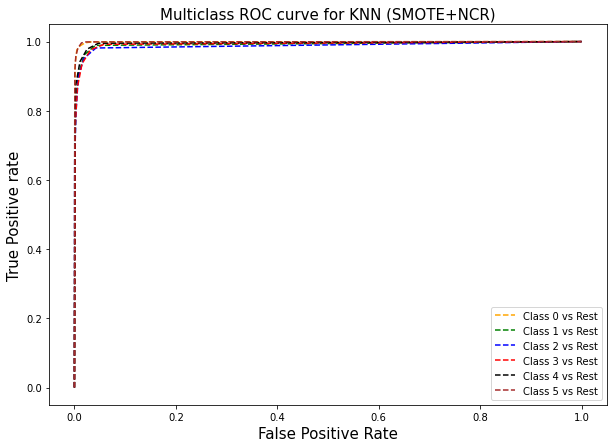

In [22]:
# roc curve for classes
plt.figure(figsize=(10,7))

fpr = {}
tpr = {}
thresh ={}

n_class = 6

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, knn_smote_ncr_pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='brown', label='Class 5 vs Rest')

plt.title('Multiclass ROC curve for KNN (SMOTE+NCR)',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive rate',fontsize=15)
plt.legend(loc='best')
# plt.savefig('Multiclass ROC',dpi=300)

print('ROC_AUC Score:',roc_auc_score(y_test, knn_smote_ncr_pred_prob,multi_class='ovr'))

In [23]:
df_acc=pd.read_csv('analysis1.csv')
df_f1=pd.read_csv('analysis2.csv')
df_pre=pd.read_csv('analysis3.csv')
df_recall=pd.read_csv('analysis4.csv')

acc=[acc_score_nb_afteros_us.round(4),acc_score_knn_afteros_us.round(4)]
f1=[f1_score_nb_afteros_us.round(4),f1_score_knn_afteros_us.round(4)]
pre=[precision_nb_afteros_us.round(4),precision_knn_afteros_us.round(4)]
recall=[recall_nb_afteros_us.round(4),recall_knn_afteros_us.round(4)]


df_acc['Combined(SMOTE+NCR)Accuracy']=acc
df_f1['Combined(SMOTE+NCR)f1 score']=f1
df_pre['Combined(SMOTE+NCR)precision']=pre
df_recall['Combined(SMOTE+NCR)recall']=recall

df_acc.drop('Unnamed: 0',axis=1,inplace=True)
df_f1.drop('Unnamed: 0',axis=1,inplace=True)
df_pre.drop('Unnamed: 0',axis=1,inplace=True)
df_recall.drop('Unnamed: 0',axis=1,inplace=True)

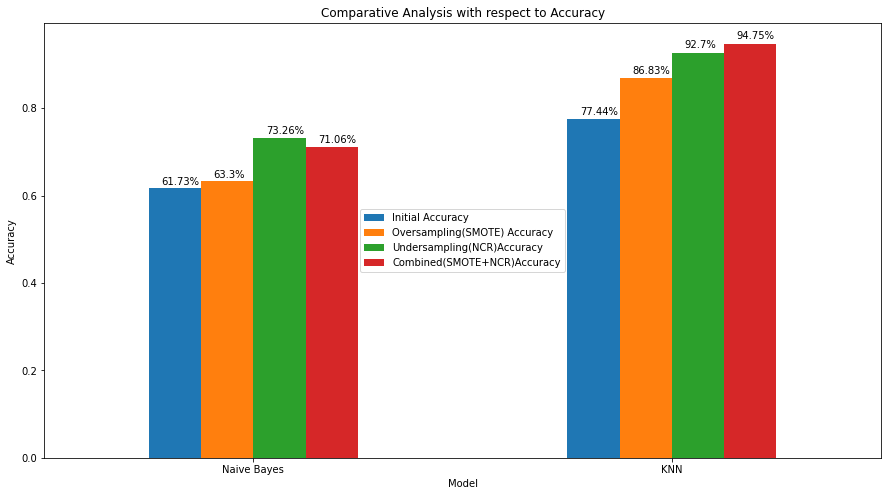

In [24]:
ax = df_acc.plot(x='Model',ylabel="Accuracy",kind='bar',legend=True,figsize=(15,8),title="Comparative Analysis with respect to Accuracy",rot=0)
plt.legend(loc='center')

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.03, i.get_height()*1.013, \
            str(round(i.get_height()*100, 2))+'%')

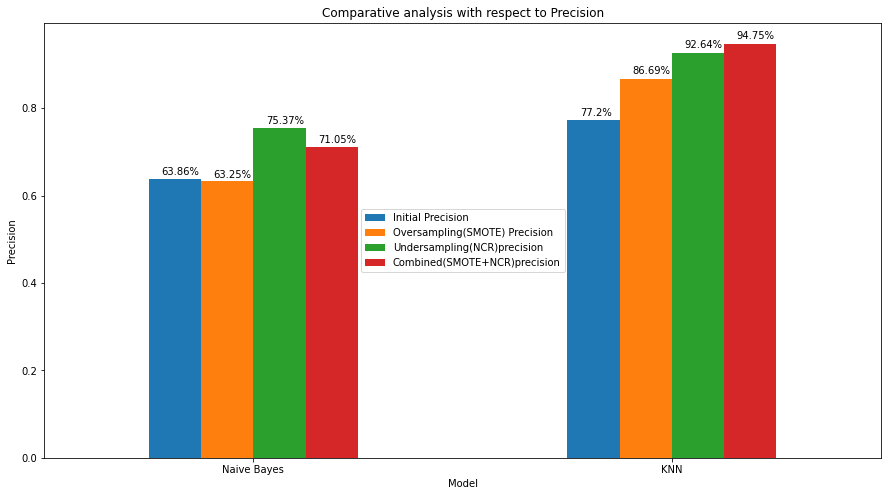

In [25]:
ax = df_pre.plot(x='Model',ylabel="Precision",kind='bar',legend=True,figsize=(15,8),title="Comparative analysis with respect to Precision",rot=0)
plt.legend(loc='center')

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.03, i.get_height()*1.013, \
            str(round(i.get_height()*100, 2))+'%')

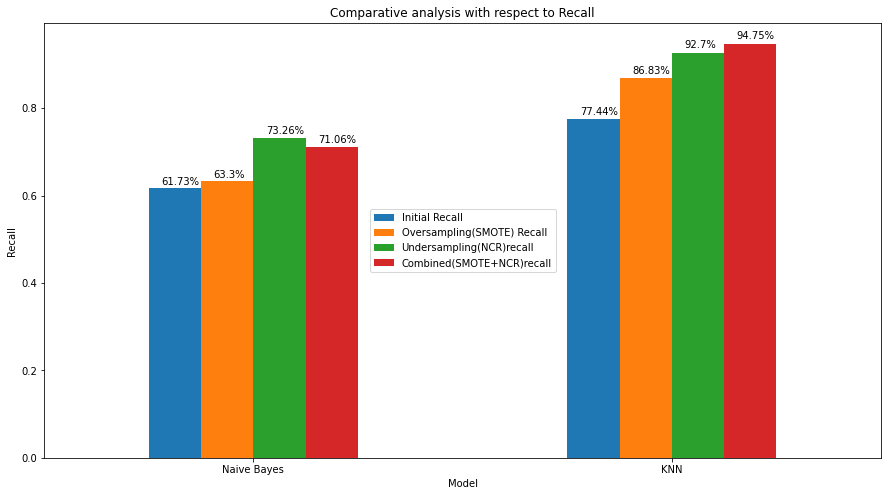

In [26]:
ax = df_recall.plot(x='Model',ylabel="Recall",kind='bar',legend=True,figsize=(15,8),title="Comparative analysis with respect to Recall",rot=0)
plt.legend(loc='center')

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.03, i.get_height()*1.013, \
            str(round(i.get_height()*100, 2))+'%')

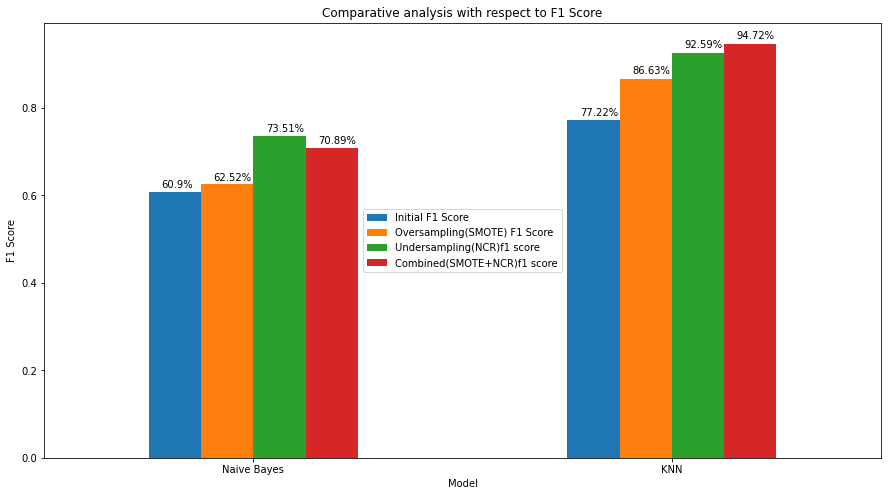

In [27]:
ax = df_f1.plot(x='Model',ylabel="F1 Score",kind='bar',legend=True,figsize=(15,8),title="Comparative analysis with respect to F1 Score",rot=0)
plt.legend(loc='center')

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x()+0.03, i.get_height()*1.013, \
            str(round(i.get_height()*100, 2))+'%')

## <center> Result Analysis </center>

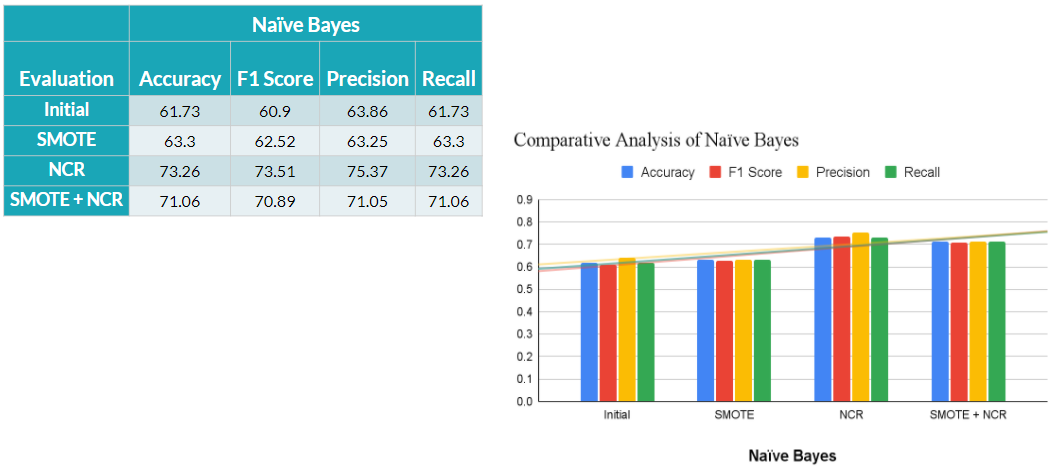

<hr/>

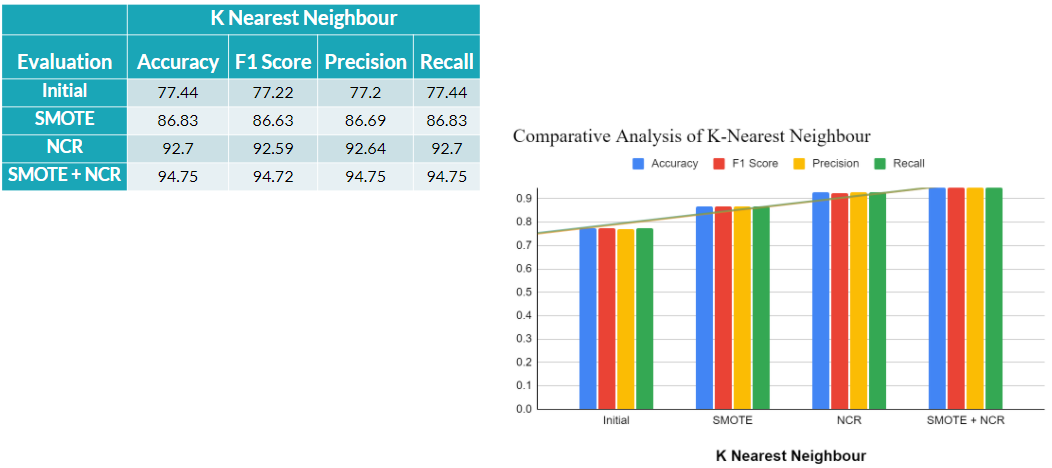

<hr/>

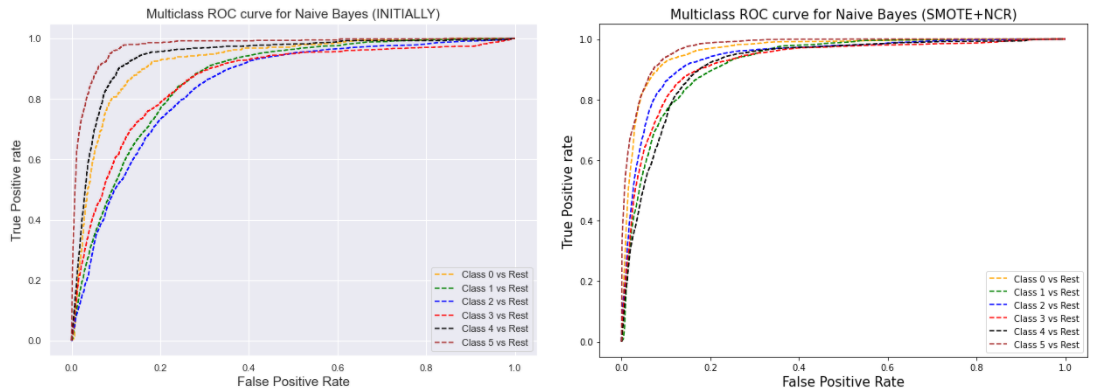
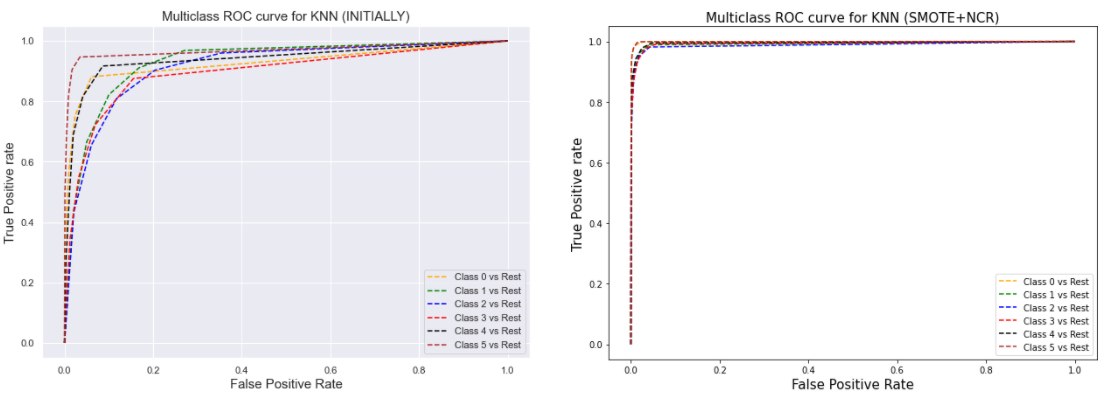